In [1]:
#Libraries to download videos from youtube
import pafy
import moviepy
# importing the youtube module 
from pytube import YouTube

In [2]:
#import Important Libraries
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
#seeting seed constant to randomization
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
#Downloading data
#here I am using UCF50 - Action Recognition Dataset
#50 action categories
#25 groups of videos per action categories
#133 Average videos per action category
#199 average number frames per video
#320 Average frames width per video
#240 average frames height per video
#26 Average frames per second per video

# Lets Download

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
    
#Unpacking

!unrar x UCF50.rar

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unrar' is not recognized as an internal or external command,
operable program or batch file.


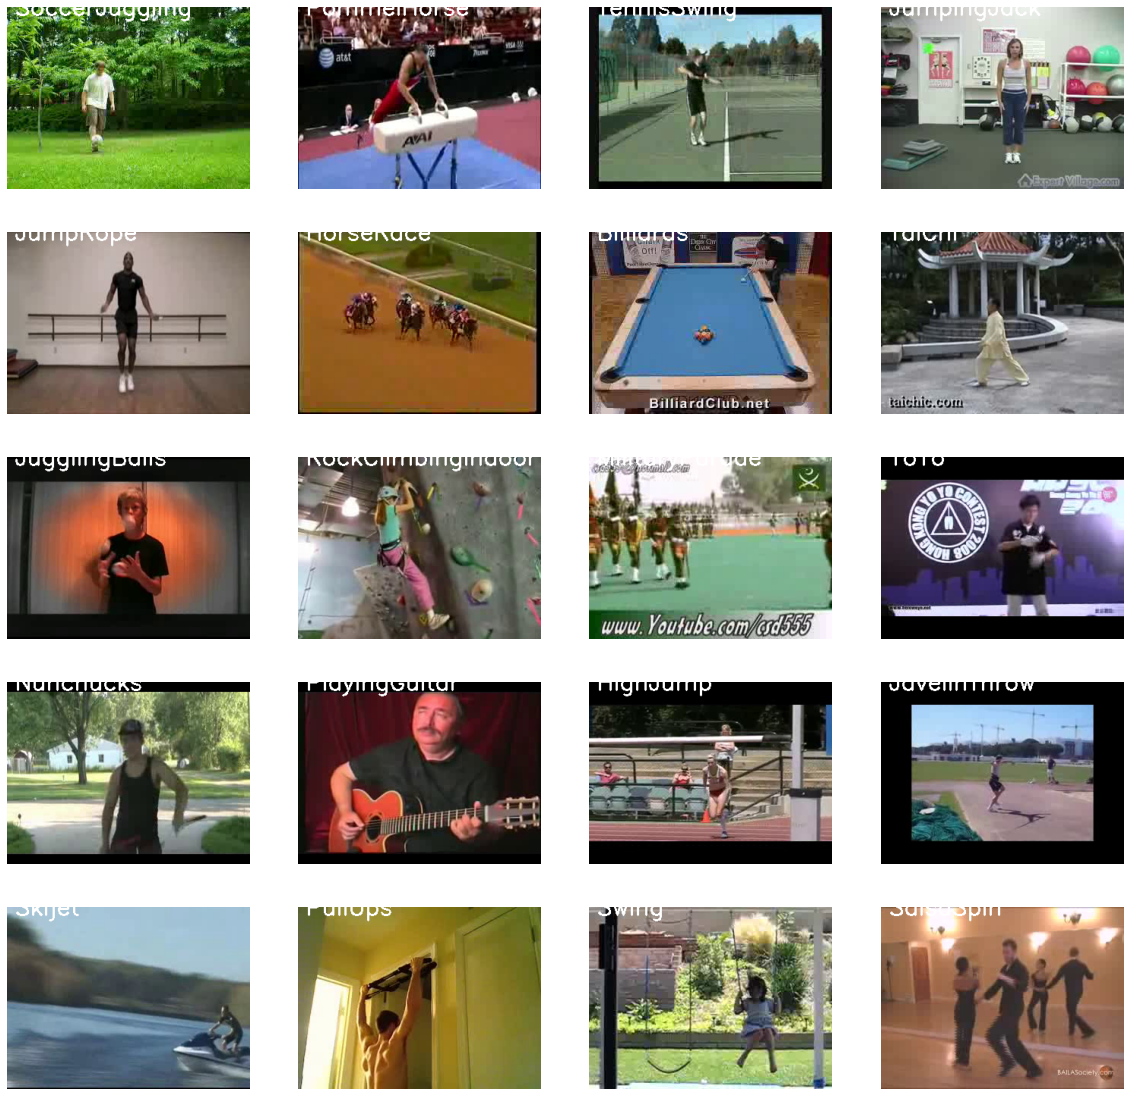

In [5]:
#creating a matplotlib figure and specifying the size
plt.figure(figsize = (20,20))

#list the names of all categories in UCF50
all_classes = os.listdir('UCF50')

#Generating a list of 20 random numbers between 0 to 50
rand_range = random.sample(range(len(all_classes)),20)

#Iterating through all random values and getting categories from the dataset
for counter, random_index in enumerate(rand_range, 1):
    #retrive a category
    selected_class = all_classes[random_index]
    
    #retrive all the video files in that category
    video_files_names = os.listdir(f'UCF50/{selected_class}')
    
    #randomly select video from the class folder
    selected_video = random.choice(video_files_names)
    
    #initialize video capture object to read from the video file
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class}/{selected_video}')
    
    #read the first frame of the video file
    _, bgr_frame = video_reader.read()
    
    #release the video capture object
    video_reader.release()
    
    #convert the frame from bgr to rgb format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    #write class name on the video frame
    cv2.putText(rgb_frame, selected_class, (10,10), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    #display the frame
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
#preprocessing
image_h, image_w = 64,64

#number of frames to be fed into the model
seq_len = 22

data_dir = 'UCF50'

#list of classes to be learnt from and predict
classes_list = ['HorseRiding','Billiards','BenchPress','MilitaryParade']

In [7]:
def frames_extraction(video_path):
    #this function will extract from video after resizing and normalizing them.
    #declare a list ro store frames list
    frames_list = []
    
    #read video file using videocapture object
    video_reader = cv2.VideoCapture(video_path)
    
    #get the total number of frames in the video
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #interval after which the frames will be added to the list
    skip_frames = max(int(frame_count/seq_len),1)
    
    #iterarte through video frames
    for frame_counter in range(seq_len):
        #set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames)
        
        #reading frame from the video
        success, frame = video_reader.read()
        
        #check if read properly
        if not success:
            break
        
        
        #resize the frame to fixed with and height
        resize_frame = cv2.resize(frame, (image_h,image_w))
        
        #normalize the resized frame 
        normal_frame = resize_frame/255
        
        #append the normalized frame into the frames list
        frames_list.append(normal_frame)
        
    video_reader.release()
    
    return frames_list

In [8]:
#function to create dataset
def create_dataset():
    #this function will extract the data of the slected classes and create the required dataset
    
    #declare empty lists to store the features, labels, and video path values
    features = []
    labels = []
    video_path_v = []
    
    #iterating through all the classes in the classes list
    for class_index, class_name in enumerate (classes_list):
        #display the name of the class whose data is being extracted
        print(f'Extracting data of calss :',class_name)
        
        #get the list of the video files present in the class
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        #iterate through all the files present in the files list
        for file_name in files_list:
            #get the complete path of the video
            video_file_path = os.path.join(data_dir, class_name, file_name)
            
            #extract the frames of the video file
            frames = frames_extraction(video_file_path)
            
            #check if extracted frames are equal to the seq_len 
            if len(frames) == seq_len:
                #appaend data in their respective lists
                features.append(frames)
                labels.append(class_index)
                video_path_v.append(video_file_path)
                
    features = np.asarray(features)
    labels = np.asarray(labels)
    
    return features, labels, video_path_v
    

In [9]:
#create dataset
features, labels, video_path_v = create_dataset()

Extracting data of calss : HorseRiding
Extracting data of calss : Billiards
Extracting data of calss : BenchPress
Extracting data of calss : MilitaryParade


In [10]:
#using keras to_categorical method to convert lables into one hot encoded vectors
lables_ohe = to_categorical(labels)

In [11]:
#train test split
f_train, f_test, l_train, l_test = train_test_split(features, lables_ohe,
                                                   test_size = 0.25, shuffle = True,
                                                   random_state = seed_constant)

In [12]:
#implementation of ConvLSTM method
def create_model():
    #this function will construct the required convlstm model
    model = Sequential()
    #############################################################################################################
    #model architecture definition
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last',
                        recurrent_dropout = 0.2, return_sequences = True, input_shape = (seq_len,image_h,image_w,3)))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', padding = 'same', data_format = 'channels_last',
                        recurrent_dropout = 0.2, return_sequences = True))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last',
                        recurrent_dropout = 0.3, return_sequences = True))
    model.add(MaxPooling3D(pool_size =(1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last',
                        recurrent_dropout = 0.3, return_sequences = True))
    model.add(MaxPooling3D(pool_size =(1,2,2), padding = 'same', data_format = 'channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten())
    
    model.add(Dense(len(classes_list), activation = "softmax"))
    ###############################################################################################################\
    #model summary
    model.summary()
    
    return model

In [13]:
cLSTM_model = create_model()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 22, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 22, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 22, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 22, 31, 31, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 22, 16, 16, 8)    0         
 3D)                                                             
                                                        

In [14]:
#plot the structure of the constructed model
plot_model(cLSTM_model, to_file = 'cLSTM.png', show_shapes = True, show_layer_names = True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
#creating instance for early stopping 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

#compile model
cLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#start training the model
cLSTM_history = cLSTM_model.fit(x = f_train, y= l_train, epochs = 20, batch_size = 5,
                               shuffle = True, validation_split = 0.2,
                               callbacks = [early_stopping])

Epoch 1/20
76/76 [==============================] - 66s 789ms/step - loss: 1.1555 - accuracy: 0.4605 - val_loss: 0.7757 - val_accuracy: 0.7053
Epoch 2/20
11/76 [===>..........................] - ETA: 45s - loss: 0.7972 - accuracy: 0.6182

KeyboardInterrupt: 

In [21]:
#evaluate the model trained
model_evaluation = cLSTM_model.evaluate(f_test,l_test)

5/5 [==============================] - 4s 605ms/step - loss: 0.1824 - accuracy: 0.9560


In [22]:
#saving the trained model
model_evaluation_loss, model_evaluation_accuracy = model_evaluation

#define date string format
date_time_format = '%Y_%m_%d_%H_%M_%S'
#get curretnt date and time
current_date_time = dt.datetime.now()
#conver the date time to defined format
current_date_time = dt.datetime.strftime(current_date_time, date_time_format)

model_name = f'cLSTM_model__Date_Time_{current_date_time}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

#save model
cLSTM_model.save(model_name)

In [23]:
#function to plot model loss and accuracy curves

def plot_metrics(model_history, metric_1, metric_2, plot_name):
    #get metric values using metric names as identifiers
    metric_1value = model_history.history[metric_1]
    metric_2value = model_history.history[metric_2]
    
    #epochs to be used as units on x axis
    epochs = range(len(metric_1value))
    
    #plot the graph
    plt.plot(epochs,metric_1value,'blue', label= metric_1)
    plt.plot(epochs,metric_2value,'red',label = metric_2)
    
    plt.title(str(plot_name))
    
    plt.legend()
    

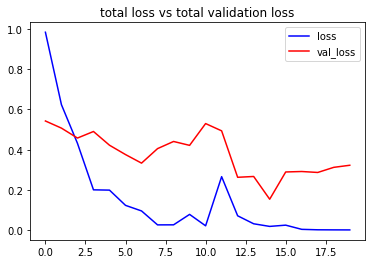

In [24]:
#viz of the training and validation loss matrices
plot_metrics(cLSTM_history,'loss','val_loss', 'total loss vs total validation loss')

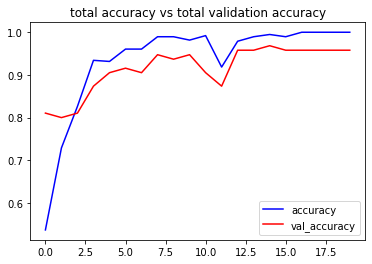

In [25]:
#viz of the training and validation accuracy
plot_metrics(cLSTM_history,'accuracy', 'val_accuracy', 'total accuracy vs total validation accuracy')

In [16]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (seq_len, image_h, image_w, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(classes_list), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [17]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 22, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 22, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 22, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 22, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 22, 4, 4, 32)    

In [18]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = f_train, y = l_train, epochs = 40, batch_size = 4 , shuffle = True,
                                             validation_split = 0.2, callbacks = [early_stopping_callback]) 

Epoch 1/40
95/95 [==============================] - 7s 56ms/step - loss: 1.2813 - accuracy: 0.3605 - val_loss: 1.0277 - val_accuracy: 0.3789
Epoch 2/40
95/95 [==============================] - 4s 47ms/step - loss: 1.0507 - accuracy: 0.4737 - val_loss: 0.8811 - val_accuracy: 0.7053
Epoch 3/40
95/95 [==============================] - 4s 44ms/step - loss: 0.7453 - accuracy: 0.6895 - val_loss: 0.8587 - val_accuracy: 0.5158
Epoch 4/40
95/95 [==============================] - 4s 46ms/step - loss: 0.6036 - accuracy: 0.7105 - val_loss: 0.3780 - val_accuracy: 0.8000
Epoch 5/40
95/95 [==============================] - 4s 47ms/step - loss: 0.5327 - accuracy: 0.7553 - val_loss: 0.5188 - val_accuracy: 0.7368
Epoch 6/40
95/95 [==============================] - 4s 45ms/step - loss: 0.4477 - accuracy: 0.8132 - val_loss: 0.4012 - val_accuracy: 0.8632
Epoch 7/40
95/95 [==============================] - 4s 45ms/step - loss: 0.4843 - accuracy: 0.8132 - val_loss: 0.3564 - val_accuracy: 0.8737
Epoch 8/40
95

KeyboardInterrupt: 

In [30]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(f_test, l_test)

5/5 [==============================] - 0s 74ms/step - loss: 0.1427 - accuracy: 0.9686


In [32]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
#Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

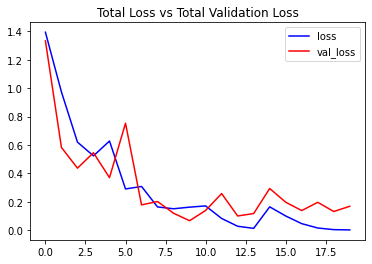

In [33]:
# Visualize the training and validation loss metrices.
plot_metrics(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

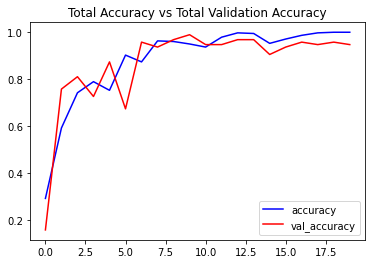

In [34]:
# Visualize the training and validation accuracy metrices.
plot_metrics(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [35]:


def download_video(link,dir):  
    
    
    try: 
        # object creation using YouTube
        # which was imported in the beginning 
        yt = YouTube(link) 
    except: 
        print("Connection Error") #to handle exception 
  
    title = yt.title   
    try: 
        # downloading the video 
        d_video.download(dir) 
    except: 
        print("Some Error!") 
    print('Task Completed!')
    
    return title

In [36]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
# Download a YouTube Video.
video_title = download_video('https://www.youtube.com/watch?v=QuKO-SXKJJA', test_videos_directory)
 
# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

Some Error!
Task Completed!


In [37]:
video_title

'Horse riding Wajid naik'

In [42]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (image_h, image_w))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = classes_list[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [43]:
# Download the youtube video.
video_title = download_video('https://www.youtube.com/watch?v=QuKO-SXKJJA', test_videos_directory)
 
# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
 
# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, seq_len)
 
# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Some Error!
Task Completed!
1/1 [==============================] - 0s 18ms/step
Action Predicted: HorseRiding
Confidence: 0.839720606803894
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (69.6) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !